In [5]:
import pandas as pd
import os,sys, imp
sys.path.append('./src/')
import doc_utils_clean as doc_utils
import feature_utils, common_utils
import defines
import numpy as np
from sklearn_crfsuite import scorers, CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import LeaveOneGroupOut,LeavePGroupsOut,GroupKFold

from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import random
import model_utils
import seaborn as sns
import matplotlib.pyplot as plt
import json
from collections import Counter
import scipy
import nltk

import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [6]:
dir_name="clean_chars"

In [3]:
db_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name)
db_path

'/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/clean_chars'

In [4]:
imp.reload(doc_utils)
doc_db =  pd.read_csv("./dataframes/doc_db.csv")
doc_db.sort_values(by='doc_idx_from_name',inplace=True)
doc_db

,path,file_name,doc_idx_from_name,par_count,sent_count,nar_sent_count
0,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,01_aingimel3_lc.docx,1,205.000000,580.000000,256.000000
1,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,02_aingimel12_lc.docx,2,157.000000,632.000000,70.000000
2,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,03_aingimel26_lc.docx,3,118.000000,559.000000,102.000000
3,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,04_nun2_lc.docx,4,132.000000,460.000000,172.000000
4,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,05_kafhey_23_lc.docx,5,65.000000,510.000000,270.000000
...,...,...,...,...,...,...
75,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,76_nun2_Mor.docx,76,132.000000,464.000000,164.000000
76,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,77_nun25_Mor.docx,77,176.000000,406.000000,64.000000
77,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,78_tsadek27_Mor.docx,78,122.000000,178.000000,44.000000
78,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,79_tsadek29_Mor.docx,79,173.000000,252.000000,70.000000


In [7]:
sent_db = common_utils.concat_dbs('recalc_tfidf',"sent_db",['text','is_nar'])

In [8]:
sent_db

,doc_idx,sent_idx,text,is_nar
0,1,0,אז היום אנחנו נפגשים פה ב18 אבל שבוע הבא בחמישי,0.000000
1,1,1,כן,0.000000
2,1,2,אוקיי מה שלומך?,0.000000
3,1,3,ברוך השם,0.000000
4,1,4,מחר יש לכם יום טיול,0.000000
...,...,...,...,...
36319,80,486,שאני מרגיש בהם לא נוח,0.000000
36320,80,487,אז כאילו למה למה אני מתגעגע,0.000000
36321,80,488,או למה אני למה אני רוצה,0.000000
36322,80,489,והצלחת לענות לעצמך?,0.000000


In [14]:
non_heb=pd.DataFrame(sent_db[~sent_db['text'].str.contains(r'[א-ת]')])
non_heb

,doc_idx,sent_idx,text,is_nar
623,2,43,XXX,0.000000
649,2,69,XXX,0.000000
661,2,81,XXX,0.000000
1400,3,188,L2R,0.000000
1715,3,503,XXX,0.000000
...,...,...,...,...
34863,76,330,XXXX,0.000000
34998,77,1,XXXX,0.000000
34999,77,2,XXXX,0.000000
35855,80,22,XXX XXX,0.000000


In [25]:
non_heb[non_heb['text'].str.contains(" ")]

,doc_idx,sent_idx,text,is_nar
7800,14,415,NICE TO HAVE,0.000000
9668,18,70,XXX XXX,0.000000
12085,25,2,XXX XXX,0.000000
12895,27,1,XXX,0.000000
16079,35,0,XXX,0.000000
16705,37,0,XXX,0.000000
16876,38,1,XXX,0.000000
17218,40,11,XXX XXX,0.000000
17433,41,5,XXX XXX,0.000000
17576,41,148,XXX XXX,0.000000


In [17]:
non_heb['text'].value_counts()

XXX             71
XXXX             6
 XXX             5
XXX XXX          5
,                2
CBT?             2
XXXX?            2
 XXX             1
NICE TO HAVE     1
so wha?          1
XXX 3350         1
XXX?             1
said who         1
  XXX XXX        1
 XXXX            1
  XXX            1
L2R              1
XXXX XXXX        1
 XXX XXX         1
Name: text, dtype: int64

In [26]:
import re
for word in non_heb['text'].value_counts().index:
    fix1=re.sub(r'X{3,4}.*?X{1,4}|X{3,}','XXX',word)
    fix2= re.sub(r'\?','',fix1)
    print (fix2)

XXX
XXX
 XXX
XXX
,
CBT
XXX
 XXX 
NICE TO HAVE
so wha
XXX 3350
XXX
said who
  XXX
 XXX
  XXX
L2R
XXX
 XXX


In [14]:
not_heb_char=sent_db[~sent_db['text'].str.contains(r'[א-ת]')]['text'].unique().tolist()

In [15]:
not_heb_char

['XXX',
 'L2R',
 'XXXX',
 'NICE TO HAVE',
 ' XXX XXX',
 'XXXX?',
 'XXX XXX',
 '  XXX',
 ' XXX',
 ' XXX ',
 '  XXX XXX',
 'XXXX XXXX',
 'CBT?',
 ' XXXX',
 ',',
 'said who',
 'so wha?',
 'XXX 3350',
 'XXX?']

## Check now many blocks contain time

In [28]:
block_db = common_utils.concat_dbs('recalc_tfidf',"block_db")
block_db

,doc_idx,block_idx,text,is_nar,doc_idx,par_idx_in_doc,par_db_idx,par_type,block_type,nar_idx
0,1,0,"\tאז היום אנחנו נפגשים פה ב18, אבל שבוע הבא בח...",0.000000,1.000000,0.000000,0.000000,therapist,not_nar,0.000000
1,1,1,\tכן,0.000000,1.000000,1.000000,1.000000,client,not_nar,0.000000
2,1,2,\tאוקיי. מה שלומך?,0.000000,1.000000,2.000000,2.000000,therapist,not_nar,0.000000
3,1,3,\tברוך השם (..),0.000000,1.000000,3.000000,3.000000,client,not_nar,0.000000
4,1,4,\tמחר יש לכם יום טיול.,0.000000,1.000000,4.000000,4.000000,therapist,not_nar,0.000000
...,...,...,...,...,...,...,...,...,...,...
15735,80,224,"\tאמ, (..) כן עם א""ת זה היה, (..) היה לא פשוט...",0.000000,80.000000,220.000000,220.000000,client,not_nar,0.000000
15736,80,225,\t(..) באמת הגעת לכאן וסיפרת שאתה מרגיש מאוד א...,0.000000,80.000000,221.000000,221.000000,therapist,not_nar,0.000000
15737,80,226,"\t נכון. כן. כן מאוד אה נפגעה, אה, אבל זה נתן ...",0.000000,80.000000,222.000000,222.000000,client,not_nar,0.000000
15738,80,227,\tוהצלחת לענות לעצמך?,0.000000,80.000000,223.000000,223.000000,therapist,not_nar,0.000000


In [41]:
block_db[block_db['text'].str.contains(r'[0-9]{1,}')]

,doc_idx,block_idx,text,is_nar,doc_idx,par_idx_in_doc,par_db_idx,par_type,block_type,nar_idx
0,1,0,"\tאז היום אנחנו נפגשים פה ב18, אבל שבוע הבא בח...",0.000000,1.000000,0.000000,0.000000,therapist,not_nar,0.000000
24,1,24,"\tאף אחד לא סבבה עם זה. כאילו כולם, זה מבאס את...",1.000000,1.000000,23.000000,23.000000,client,middle,1.000000
32,1,32,\tאבל אני (..) אבל כל מעבר זה היה להכיר אנשים ...,1.000000,1.000000,31.000000,31.000000,client,end,1.000000
35,1,35,"\tאממ ההורים שלי (..) הם כבר, כאילו אבא שלי כב...",0.000000,1.000000,33.000000,33.000000,client,not_nar,0.000000
43,1,43,"\tיהודי טוב כזה, כן. אמא שלי, היא (..) ילידת א...",0.000000,1.000000,41.000000,41.000000,client,not_nar,0.000000
...,...,...,...,...,...,...,...,...,...,...
15499,79,175,"\tאבל אני מאוד מבין, (..) את התחושה הזאתי של ה...",0.000000,79.000000,162.000000,162.000000,therapist,not_nar,0.000000
15510,79,186,"\tאני שומע ככה אבל את הדברים שאתה אומר, והרצון...",0.000000,79.000000,172.000000,172.000000,therapist,not_nar,0.000000
15550,80,39,"\tסבבה. אז אה, קודם כל, זה באמת מאוד נכון מה ש...",0.000000,80.000000,39.000000,39.000000,therapist,not_nar,0.000000
15587,80,76,"\tשבעצם אולי, הצטיידת קצת ב, צידה לדרך ו, [נכו...",0.000000,80.000000,75.000000,75.000000,therapist,not_nar,0.000000


### Parse doc with cleaning sentenses

In [34]:
import hebrew_tokenizer as ht
def tokenize_time(text):
    tokens = ht.tokenize(hebrew_text)
    for grp, token, token_num, (start_index, end_index) in tokens:
        print('{}, {}'.format(grp, token))
    

/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/hebrew_tokenizer/tokenizer.py:121: FutureWarning: Possible nested set at position 729
  self.scanner = re.compile(


In [40]:
hebrew_text=block_db.loc[24,'text']
print(hebrew_text)
tokenize_time(hebrew_text)

	אף אחד לא סבבה עם זה. כאילו כולם, זה מבאס את כולם. כל אחד התרגל כבר למקום שלו את הנישה שלו ואת הכל. וכל החברה עוברת, אין אף אחד שנשאר, חוץ מהמנהלים, אבל אין אף אחד שנשאר במקום שלו. אז יש כאלה שעוברים למקומות טיפה יותר טובים יש כאלה למקומות פחות טובים. אנחנו, הצוות שלי שהוא, אנחנו 4 אנשים, אז אנחנו עוברים ליחסית מקום מבודד, מכל השאר. כאילו, לא מבודד אתה יודע, זה מרחק של מטרים זה לא איזה שני מטר שלוש מטר. אבל זה לא עם כולם. אני אוהב תמיד לשבת עם כולם, אני אוהב להיות עם כולם. באמצע שאם יש צחוקים אני אוהב להיות במרכז העניינים לדעת מה קורה, ופה אני קצת, דחקו אותנו אחורה ואותי בפרט כאילו אני גם יושב רחוק מכולם, אבל אה בסדר. אף פעם לא היה לי בעיות עם מקומות. כאילו זה עברתי הרבה פעמים מקומות בחברה, אף פעם לא התלוננתי. כאילו מתרגלים, כל מקום מתרגלים. אני יותר (..) אוהב עם כולם. אבל בסדר, מקווה שיהיה בסדר.
HEBREW, אף
HEBREW, אחד
HEBREW, לא
HEBREW, סבבה
HEBREW, עם
HEBREW, זה
PUNCTUATION, .
HEBREW, כאילו
HEBREW, כולם
PUNCTUATION, ,
HEBREW, זה
HEBREW, מבאס
HEBREW, את
HEBREW, כולם
PUNCTUATION, .
HE

In [54]:
%%time
# define fixed parameters and parameters to search
my_cv=model_utils.ByDocFold()
crf_scaled = CRF(
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'algorithm': ['lbfgs' ,'l2sgd','ap','pa','arow'],
    'min_freq': np.arange(1,11,2) 
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs_scaled = RandomizedSearchCV(crf_scaled, params_space,
                        cv=my_cv,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)


rs_scaled.fit(X=X_train, y=y_train,groups=groups_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
123 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimator.py", line 310, in fit
    trainer = self._get_trainer()
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimat

CPU times: user 4min 25s, sys: 51.7 s, total: 5min 17s
Wall time: 5min 33s


RandomizedSearchCV(cv=<model_utils.ByDocFold object at 0x2ab18a926280>,
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ab18a926670>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ab18a9269a0>,
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

In [55]:
# crf = rs.best_estimator_
print('best params:', rs_scaled.best_params_)
print('best CV score:', rs_scaled.best_score_)
print('model size: {:0.2f}M'.format(rs_scaled.best_estimator_.size_ / 1000000))

best params: {'algorithm': 'lbfgs', 'c1': 2.2094463444672967, 'c2': 0.04237509592809371, 'min_freq': 7}
best CV score: 0.7875252996364037
model size: 0.10M


In [56]:
import json
imp.reload(common_utils)
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"best_params_max.abs.scaled.json")

best_params_pyth = common_utils.convert_to_python_types(rs_scaled.best_params_)
with open(json_path, 'w') as fp:
    json.dump(best_params_pyth, fp)



              precision    recall  f1-score   support

      is_nar       0.68      0.60      0.64      2089
     not_nar       0.85      0.89      0.87      5227

    accuracy                           0.80      7316
   macro avg       0.76      0.74      0.75      7316
weighted avg       0.80      0.80      0.80      7316



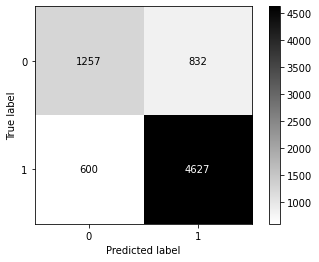

In [57]:
best_crf = rs_scaled.best_estimator_
y_pred  =  best_crf.predict(X_test)
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred),crf_scaled.classes_)

### Look at the features


In [70]:
imp.reload(model_utils)
all_features_cv = model_utils.get_features_df(dir_name,Counter(best_crf.state_features_).most_common())

In [74]:
all_features_cv.iloc[:30,:]

,weight,label,attr,string
0,1.644582,not_nar,tfidf_word_17103,מחפשים
1,1.383846,is_nar,tfidf_word_23945,שלח
2,1.317247,not_nar,-1:sent_pos_in_par,
3,1.218701,is_nar,tfidf_char_wb_30121,רה
4,1.021945,is_nar,tfidf_lemma_1604,גוגל
5,0.980243,is_nar,tfidf_char_wb_33063,תי
6,0.977849,not_nar,tfidf_lemma_1284,בין
7,0.966310,not_nar,tfidf_lemma_2823,הרגיע
8,0.957415,is_nar,tfidf_lemma_9681,שריטה
9,0.932285,is_nar,tfidf_word_5273,החברה


In [7]:
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"my_stop_words.json")
with open(json_path, 'r') as fp:
    my_stop_words = json.load(fp)

json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"my_stop_lemmas.json")
with open(json_path, 'r') as fp:
    my_stop_lemmas = json.load(fp)

In [11]:
imp.reload(feature_utils)
stop_words_num=270
stop_lemmas_num=45
tf_char = feature_utils.tfidf_build_all_save_per_doc(dir_name,per_word=False,per_lemma=False,analyzer="char_wb")
tf_lemma = feature_utils.tfidf_build_all_save_per_doc(dir_name,per_word=True,per_lemma=True,analyzer="word",stop_words=my_stop_words[:stop_words_num])
tf_word = feature_utils.tfidf_build_all_save_per_doc(dir_name,per_word=True,per_lemma=False,analyzer="word",stop_words=my_stop_lemmas[:stop_lemmas_num])

TfIdf char_wb vocab size 33783
Sample of 33783 features
[' 1 ', ' 10', ' 10 ', ' 100', ' 100 ', ' 11', ' 11 ', ' 12', ' 12 ', ' 13', ' 13 ', ' 14', ' 14 ', ' 15', ' 15 ', ' 150', ' 150 ', ' 16', ' 16 ', ' 17']
['ועם', 'ועם ', 'ועמ', 'ועמד', 'ועמדי', 'וענ', 'ועני', 'ועניי', 'וענת', 'וענת ', 'ועס', 'ועס ', 'ועסת', 'ועסת ', 'ועץ', 'ועץ ', 'ועצ', 'ועצה', 'ועצה ', 'ועק']
[' 1 ', ' ושו', ' עורכ', 'בבית', 'היגה', 'וענת', 'ינקט', 'מבחן', 'סיפור', 'ריחו', '״ל ']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 TfIdf lemma vocab size 9984
Sample of 9984 features
['CBT', 'CBTיסטי', 'DNA', 'DO', 'HAVE', 'HIV', 'Inciden', 'LEVEL', 'LIST', 'Lierally', 'NICE', 'NLP', 'OCD', 'OFF', 'ON', 'SAY', 'SMS', 'SO', 'TO', 'TRX']
['לטאבו', 'לטיני', 'לטקס', 'לטש', 'ליאורה', 'ליב', 'ליבן', 'ליגה', 'ליד', 'לידה', 'לידי', 'לידים', 'ליווה

In [36]:
tf_features = {}
tf_features['word'] = tf_word.get_feature_names_out()
tf_features['lemma'] = tf_lemma.get_feature_names_out()
tf_features['char_wb'] = tf_char.get_feature_names_out()

In [41]:
imp.reload(feature_utils)
imp.reload(defines)
docs_map = feature_utils.pack_all_doc_sentences_to_map(dir_name,per_par=True,limit=0,doc_as_sequence=1,sent_lemma_db_list=[],tf_types = ['lemma','word','char_wb'])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 
14918 items packed for 80 docs


### Save packed docs features to json file

In [42]:
imp.reload(feature_utils)
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"docs_map.json")
with open(json_path, 'w') as fp:
    json.dump(json_path,fp)


### Save tf-idf features to json file

In [60]:
imp.reload(common_utils)
tf_f_list  =common_utils.convert_to_list(tf_features)
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"tf_features_map.json")
with open(json_path, 'w') as fp:
    json.dump(tf_f_list, fp)

In [61]:
tf_f_list.keys()

dict_keys(['word', 'lemma', 'char_wb'])

In [62]:
json_path

'/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/tf_stop_w/tf_features_map.json'

In [43]:
imp.reload(feature_utils)
imp.reload(model_utils)
seq_len=3
step=3
per_par=True
feature_utils.reshape_docs_map_to_seq(docs_map,per_par,seq_len,step)

[4] 132 -> 44 [11] 121 -> 41 [30] 82 -> 28 [25] 122 -> 41 [72] 420 -> 140 [67] 407 -> 136 [58] 384 -> 128 [79] 172 -> 58 [46] 200 -> 67 [53] 149 -> 50 [40] 148 -> 50 [55] 249 -> 83 [74] 95 -> 32 [61] 433 -> 145 [36] 87 -> 29 [23] 74 -> 25 [9] 276 -> 92 [28] 167 -> 56 [80] 223 -> 75 [2] 156 -> 52 [17] 322 -> 108 [31] 79 -> 27 [24] 158 -> 53 [5] 65 -> 22 [10] 123 -> 41 [47] 160 -> 54 [52] 275 -> 92 [78] 122 -> 41 [59] 370 -> 124 [73] 85 -> 29 [66] 366 -> 122 [75] 68 -> 23 [60] 245 -> 82 [41] 137 -> 46 [54] 243 -> 81 [3] 113 -> 38 [16] 102 -> 34 [29] 105 -> 35 [8] 82 -> 28 [37] 99 -> 33 [22] 89 -> 30 [51] 208 -> 70 [44] 199 -> 67 [65] 335 -> 112 [70] 183 -> 61 [18] 62 -> 21 [27] 67 -> 23 [32] 73 -> 25 [13] 90 -> 30 [6] 420 -> 140 [39] 111 -> 37 [15] 121 -> 41 [21] 108 -> 36 [34] 49 -> 17 [49] 206 -> 69 [63] 338 -> 113 [76] 132 -> 44 [57] 271 -> 91 [42] 136 -> 46 [68] 439 -> 147 [64] 347 -> 116 [71] 156 -> 52 [50] 184 -> 62 [45] 204 -> 68 [38] 90 -> 30 [12] 150 -> 50 [7] 248 -> 83 [26] 114

In [44]:
docs_map[1].keys()

dict_keys(['X', 'y', 'groups', 'X_3_3', 'y_3_3', 'groups_3_3'])

### Run single example - sequence = 3x paragraph [1:3][4:6]...

In [45]:
import scipy
import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [46]:
imp.reload(model_utils)
test_percent = 0.2
seed=42
num_splits=10
X_train,y_train,X_test,y_test,test_idx,groups_train,groups_test =  model_utils.split_test_train_docs(docs_map,test_percent,seq_len,step,seed)

In [47]:
X_train[1]

[{'is_question': 0.0,
  'par_idx_in_doc': 3.0,
  'sent_len': 8.0,
  'is_client': 1,
  'sent_idx_in_par': 0,
  'sent_pos_in_par': 1.0,
  'sent_pos_in_doc': 0.0068965517241379,
  'TOKEN': 2,
  'POSTAG_DEF': 1.0,
  'POSTAG_NN': 0.5,
  'POSTAG_PREPOSITION': 0.5,
  'POSTAG_RB': 0.5,
  'f_gen_M': 0.5,
  'f_num_S': 0.5,
  'sent_idx': 3,
  '-1:is_question': 1.0,
  '-1:par_idx_in_doc': 2.0,
  '-1:sent_len': 15.0,
  '-1:is_client': 0,
  '-1:sent_idx_in_par': 0,
  '-1:sent_pos_in_par': 1.0,
  '-1:sent_pos_in_doc': 0.0051724137931034,
  '-1:TOKEN': 3,
  '-1:POSTAG_DEF': 0.3333333333333333,
  '-1:POSTAG_NN': 0.3333333333333333,
  '-1:POSTAG_NNP': 0.3333333333333333,
  '-1:POSTAG_PREPOSITION': 0.3333333333333333,
  '-1:POSTAG_QW': 0.3333333333333333,
  '-1:POSTAG_REL': 0.3333333333333333,
  '-1:f_gen_M': 0.6666666666666666,
  '-1:f_num_P': 0.3333333333333333,
  '-1:f_num_S': 0.3333333333333333,
  '+1:is_question': 0.0,
  '+1:par_idx_in_doc': 4.0,
  '+1:sent_len': 19.0,
  '+1:is_client': 0,
  '+1:sen

In [48]:
%%time
# define fixed parameters and parameters to search
my_cv=model_utils.ByDocFold()
crf = CRF(
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'algorithm': ['lbfgs' ,'l2sgd','ap','pa','arow'],
    'min_freq': np.arange(1,11,2) 
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=my_cv,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)


rs.fit(X=X_train, y=y_train,groups=groups_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
117 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimator.py", line 310, in fit
    trainer = self._get_trainer()
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn_crfsuite/estimat

CPU times: user 4min 25s, sys: 44.7 s, total: 5min 9s
Wall time: 5min 24s


RandomizedSearchCV(cv=<model_utils.ByDocFold object at 0x2b1f4abd00d0>,
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b1f5c0c8d60>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b1f4aec5a30>,
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

In [49]:
rs

RandomizedSearchCV(cv=<model_utils.ByDocFold object at 0x2b1f4abd00d0>,
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b1f5c0c8d60>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2b1f4aec5a30>,
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

In [50]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'algorithm': 'lbfgs', 'c1': 0.4128441376532073, 'c2': 0.08264281499615177, 'min_freq': 5}
best CV score: 0.8017501146727204
model size: 0.64M


In [51]:
def convert_to_python_types(_dic):
    dic = {}
    for key,val in _dic.items():
        if not isinstance(val,str):
            dic[key]=val.item()
        else:
            dic[key]=val
    return dic

In [63]:
import json
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"best_params_stop_lemma.word.json")

best_params_pyth = convert_to_python_types(rs.best_params_)
with open(json_path, 'w') as fp:
    json.dump(best_params_pyth, fp)


In [53]:
best_crf = rs.best_estimator_
y_pred  =  best_crf.predict(X_test)


              precision    recall  f1-score   support

      is_nar       0.71      0.61      0.66      2089
     not_nar       0.85      0.90      0.88      5227

    accuracy                           0.82      7316
   macro avg       0.78      0.76      0.77      7316
weighted avg       0.81      0.82      0.82      7316



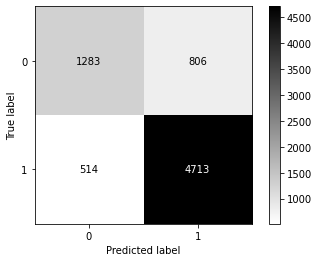

In [54]:
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred),crf.classes_)

### Look at the features

In [64]:
imp.reload(model_utils)
all_features_cv = model_utils.get_features_df(dir_name,Counter(best_crf.state_features_).most_common())

In [65]:
all_features_cv.describe()

,weight
count,10532.000000
mean,0.025757
std,0.185030
min,-1.491894
25%,-0.000057
50%,0.000001
75%,0.001799
max,2.312541


In [66]:
all_features_cv[all_features_cv['label']=='is_nar'].head(30)

,weight,label,attr,string
1,2.079952,is_nar,tfidf_word_25938,תקשיבי
2,2.047576,is_nar,tfidf_lemma_926,ארגן
3,2.046267,is_nar,tfidf_lemma_505,איכל
4,1.997642,is_nar,tfidf_lemma_4385,יישב
5,1.894588,is_nar,tfidf_lemma_9204,שיר
6,1.869153,is_nar,tfidf_word_23910,שלח
9,1.661181,is_nar,tfidf_word_22274,שאל
10,1.633130,is_nar,tfidf_lemma_1533,גוגל
18,1.491894,is_nar,tfidf_char_wb_413,אמר
20,1.454677,is_nar,tfidf_lemma_9028,שוטר


In [67]:
all_features_cv[all_features_cv['attr'].str.contains('idx')]

,weight,label,attr,string
1468,0.028631,is_nar,sent_idx_in_par,
1499,0.026161,not_nar,+2:sent_idx_in_par,
1765,0.013938,is_nar,+1:sent_idx_in_par,
2178,0.006437,not_nar,-1:sent_idx_in_par,
2626,0.001821,not_nar,-2:sent_idx_in_par,
2947,0.000770,not_nar,par_idx_in_doc,
3149,0.000460,not_nar,sent_idx,
3263,0.000350,is_nar,+2:par_idx_in_doc,
3361,0.000276,is_nar,-1:par_idx_in_doc,
3424,0.000229,is_nar,-2:par_idx_in_doc,


In [68]:
all_features_cv[all_features_cv['attr'].str.contains('tense')]

,weight,label,attr,string
409,0.359149,is_nar,f_tense_PAST,
480,0.299412,is_nar,-1:f_tense_PAST,
512,0.277776,is_nar,+1:f_tense_PAST,
521,0.274479,is_nar,-2:f_tense_PAST,
574,0.243155,is_nar,+2:f_tense_PAST,
1056,0.072658,not_nar,f_tense_FUTURE,
1181,0.054359,not_nar,-1:f_tense_IMPERATIVE,
1239,0.046593,not_nar,-2:f_tense_IMPERATIVE,
1340,0.037275,not_nar,f_tense_IMPERATIVE,
1405,0.032611,not_nar,+2:f_tense_IMPERATIVE,


In [69]:
all_features_cv[~all_features_cv['attr'].str.contains('tf')]

,weight,label,attr,string
123,0.829755,not_nar,-1:f_suf_gen_F,
264,0.529774,not_nar,f_suf_gen_F,
265,0.528853,not_nar,-1:f_per_2,
346,0.418242,not_nar,f_per_2,
409,0.359149,is_nar,f_tense_PAST,
...,...,...,...,...
10395,-0.359149,not_nar,f_tense_PAST,
10425,-0.418242,is_nar,f_per_2,
10462,-0.528853,is_nar,-1:f_per_2,
10463,-0.529774,is_nar,f_suf_gen_F,


### Save all features db

In [70]:
f_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"crf_features.csv")
all_features_cv.to_csv(f_path,index=False)

## Feature selection based on weight

<AxesSubplot:ylabel='Frequency'>

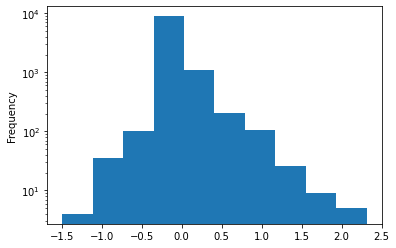

In [71]:
all_features_cv['weight'].plot(kind='hist',logy=True)

In [72]:
q = all_features_cv['weight'].quantile(q=[0.1, 0.9])
q

0.100000   -0.012706
0.900000    0.073464
Name: weight, dtype: float64

In [339]:
q.iloc[0],q.iloc[1]

(-0.022233799999999998, 0.096775)